In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np

In [2]:
file_path = 'php50jXam.arff'
data, meta = arff.loadarff(file_path)

df = pd.DataFrame(data)
for column in df.columns:
    if df[column].dtype == object:
        df[column] = df[column].str.decode('utf-8')
        
from sklearn.preprocessing import OrdinalEncoder
df["Class"] = OrdinalEncoder().fit_transform(df[["Class"]]).astype(int)
df

,V1,V2,V3,V4,Class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [3]:
features = df.iloc[:, 0:4]
target = df['Class']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, 
                                                    target, test_size=0.3, 
                                                    random_state=0, 
                                                    stratify=target)

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C=0.01, solver="lbfgs", random_state=42)
scaler = StandardScaler()

## Assuming we need to normalized the data 
normalized_x_train = pd.DataFrame(
    scaler.fit_transform(x_train),
    columns = x_train.columns
)

log_reg.fit(normalized_x_train, y_train)

normalized_x_test = pd.DataFrame(
    scaler.transform(x_test),
    columns = x_test.columns
)

y_test_pred = log_reg.predict(normalized_x_test)

In [4]:
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, auc, average_precision_score

def evaluation(classifier, X, y):
    y_predict_proba = classifier.predict_proba(X)[:, 1]
    
    precision, recall, threshold = precision_recall_curve(y, y_predict_proba)
    # Alternatively: roc_auc_score(y, y_predict_proba)
    
    fpr, tpr, thr = roc_curve(y, y_predict_proba)
    # Alternatively: average_precision_recall (y, y_predict_proba) with somewhat slight difference
    
    return{
        "ROC AUC": auc(fpr, tpr), # Alternatively: roc_auc_score(y, y_predict_proba)
        "PR AUC" : auc(recall, precision) # Alternatively: average_precision_recall (y, y_predict_proba) with slight difference
    }

In [5]:
classifier = LogisticRegression(C= 0.01, solver="lbfgs", random_state=42)

classifier.fit(x_train, y_train)
evaluation(classifier, x_train, y_train)

{'ROC AUC': 0.9994463752960355, 'PR AUC': 0.9993226297818847}

In [6]:
classifier.fit(x_test, y_test)
evaluation(classifier, x_test, y_test)

{'ROC AUC': 0.9996897892953445, 'PR AUC': 0.999616952640762}

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
# resetting training and test data
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

pipe = make_pipeline(
    StandardScaler(), 
    log_reg
)

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


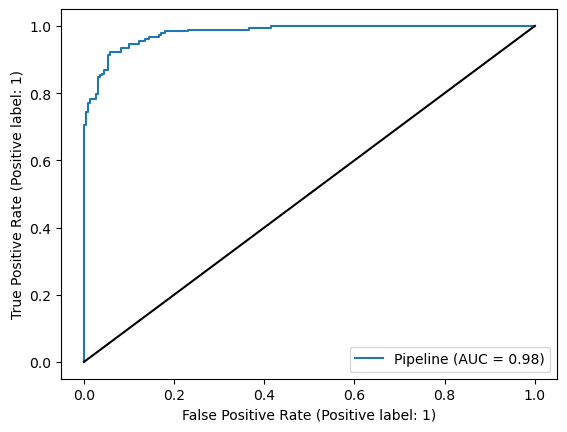

In [8]:
import matplotlib.pyplot as plt

pipe.fit(x_test, y_test)
plot_roc_curve(pipe, x_test, y_test)
plt.plot([0.,1], [0,1], c="k")

In [9]:
y_test.value_counts()

0    229
1    183
Name: Class, dtype: int64

In [10]:
183 / (229+183)

0.4441747572815534

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


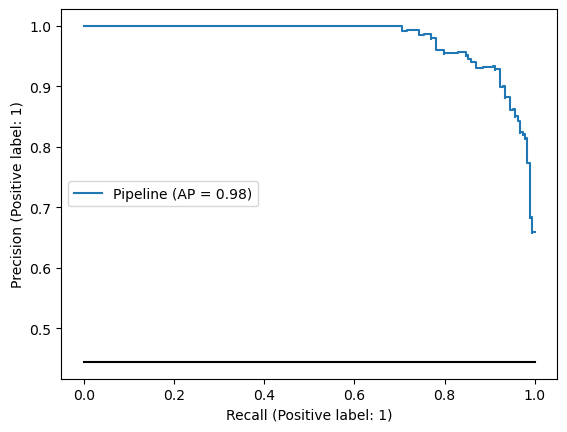

In [11]:
plot_precision_recall_curve(pipe, x_test, y_test)
plt.plot([0,1], [0.4441747572815534, 0.4441747572815534],  c='k') #baseline classifier
plt.legend(loc='best')

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


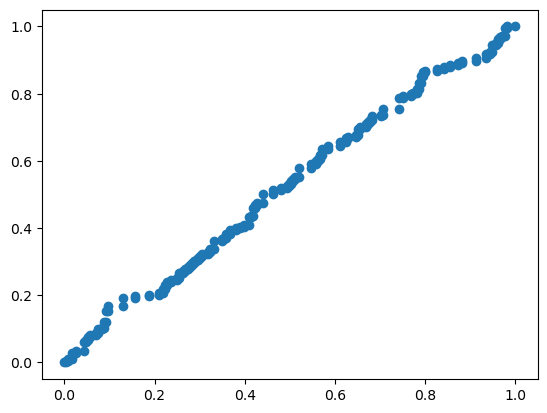

In [12]:
y_proba = log_reg.predict_proba(normalized_x_test)[:, 1]

fpr, tpr, threshold = roc_curve(y_test, y_proba)
plt.scatter(fpr, tpr)

In [13]:
pd.DataFrame({
    'fpr':fpr,
    'tpr':tpr,
    'thr':threshold
}).head()

,fpr,tpr,thr
0,0.000000,0.000000,1.833477
1,0.004367,0.000000,0.833477
2,0.004367,0.005464,0.831686
3,0.008734,0.005464,0.827948
4,0.008734,0.010929,0.822402


In [39]:
import shap
import sklearn

In [40]:
shap.initjs()

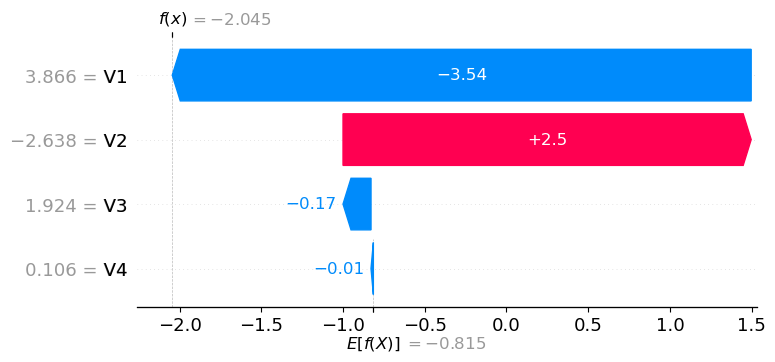

In [41]:
# Create a SHAP explainer object
explainer = shap.Explainer(log_reg, features)

# Calculate SHAP values for a single instance (you can choose any instance from X_test)
shap_values = explainer(features)

shap.plots.waterfall(shap_values[2], max_display=5)
plt.show()